In [9]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations_with_replacement
from functools import reduce
from operator import mul
from math import factorial
import einops
from koopman.simulation.simulator import simulate, simulate_batch
from koopman.simulation.systems import DynamicalSystem, Pendulum
from koopman.edmd.edmd import eDMD
from sklearn.preprocessing import PolynomialFeatures
from spatialmath.base import angle_wrap
from scipy.ndimage import gaussian_filter1d
from sklearn.preprocessing import PolynomialFeatures
from sklearn.kernel_approximation import RBFSampler
from numpy.polynomial.chebyshev import Chebyshev

In [60]:
def generate_random_smooth_controls(N, T):
    dt = 0.05
    w = np.random.randn(N, T, 1) * np.sqrt(dt)
    b = np.cumsum(w, axis=1)
    b_smooth = gaussian_filter1d(b, sigma=10, axis=1)
    
    return b_smooth

# Run a simulation with a pendulum
pendulum = Pendulum(Pendulum.Params(m=1, l=1, g=9.81, b=0.0))

N = 5_000
theta0 = np.random.uniform(-np.pi, np.pi, (N, 1))
omega0 = np.random.uniform(-3.0, 3.0, (N, 1))
x0 = np.hstack((theta0, omega0))
tf = 5.0
dt = 0.05
controls = generate_random_smooth_controls(N, int(tf/dt))
# controls = np.zeros((N, int(tf/dt), 1))

ts, xhist, uhist = simulate_batch(
    sys=pendulum,
    tf=tf,
    dt=dt,
    u=controls,
    x0=x0
)

print("ts:", ts.shape)
print("xhist:", xhist.shape)
print("uhist:", uhist.shape)

Simulation progress:   0%|          | 0/100 [00:00<?, ?it/s]

Simulation progress: 100%|██████████| 100/100 [00:00<00:00, 2343.32it/s]

ts: (101,)
xhist: (5000, 101, 2)
uhist: (5000, 100, 1)


In [70]:
def compute_rbf_observables(X, centers, sigma):
    # X: (N_samples, state_dim)
    # centers: (N_rbf, state_dim)
    diffs = X[:, None, :] - centers[None, :, :]  # (N_samples, N_rbf, state_dim)
    sq_dists = np.sum(diffs ** 2, axis=-1)       # (N_samples, N_rbf)
    return np.exp(-sq_dists / (2 * sigma**2))    # (N_samples, N_rbf)

def koopman_observables(xhist: np.ndarray, deg=None) -> np.ndarray:
    is_batched = xhist.ndim == 2
    if not is_batched:
        xhist = np.expand_dims(xhist, axis=0)
    
    B, _ = xhist.shape
    centers = np.column_stack([
        np.sin(np.linspace(-np.pi, np.pi, 20)),
        np.cos(np.linspace(-np.pi, np.pi, 20)),
        np.linspace(-3.0, 3.0, 20)
    ])
    
    X = np.column_stack([
        np.sin(xhist[:, 0]),
        np.cos(xhist[:, 0]),
        xhist[:, 1],
    ])
    
    rbfs = compute_rbf_observables(X, centers, sigma=0.2)    
    theta, omega = xhist[:, 0], xhist[:, 1]

    Y = np.column_stack([
        np.sin(theta),
        np.cos(theta),
        np.cos(theta) * omega,
        np.sin(theta) * omega**2,
        np.cos(theta) * np.sin(theta),
    ])
    
    out = np.concatenate([
        xhist, Y
    ], axis=-1)
    
    if not is_batched:
        return np.squeeze(out, axis=0)
    else:
        return out

# Fit the eDMD model to pendulum data using degree 4 polynomial observables of sin/cos/omega
edmd = eDMD()
zhist = edmd.apply_observable_to_history(xhist, koopman_observables)

print(np.max(zhist))
print(np.min(zhist))
print(np.isnan(zhist).any())
print(np.isinf(zhist).any())

assert np.allclose(zhist[:, 0, :Pendulum.nx], xhist[:, 0, :])

_ = edmd.fit(zhist , uhist, nx=Pendulum.nx, alpha=0.1)

703.6471146739334
-697.624370185295
False
False
zhist shape: (5000, 101, 7)
uhist shape: (5000, 100, 1)
Number of samples: 5000
Number of time steps: 101
Number of states: 7
Number of controls: 1
kpA shape: (7, 7)
kpB shape: (7, 1)
Condition number of kpA: 28.454279249869526
Condition number of kpB: 1.0


Simulation progress: 100%|██████████| 100/100 [00:00<00:00, 21415.90it/s]


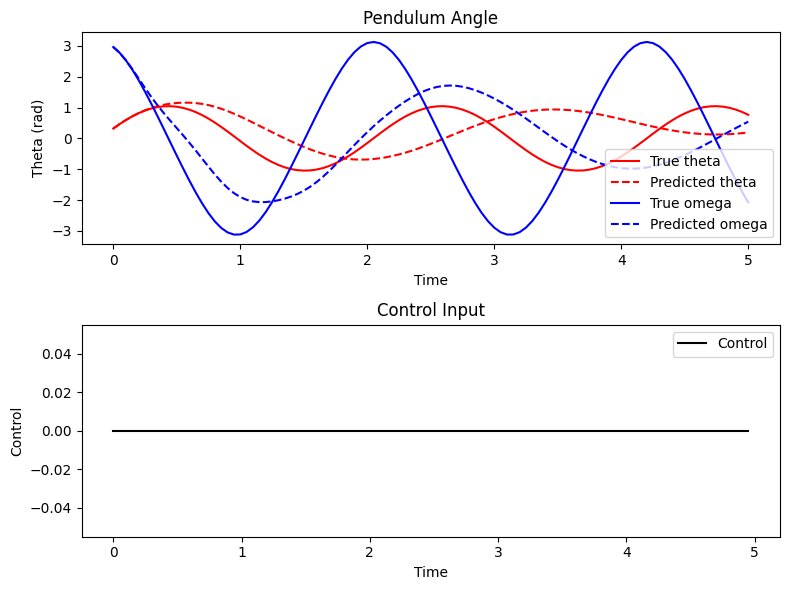

In [71]:
# Evaluate the model on some new data
theta0 = np.random.uniform(-np.pi, np.pi, 1)
omega0 = np.random.uniform(-5.0, 5.0, 1)
x0 = np.concatenate((theta0, omega0))
controls = np.zeros((int(tf/dt), 1)) #np.squeeze(generate_random_smooth_controls(1, int(tf/dt)), axis=0)

eval_ts, eval_xhist, eval_uhist = simulate(
    sys=pendulum,
    tf=tf,
    dt=dt,
    u=controls,
    x0=x0
)

zjm1 = koopman_observables(x0, deg=2)

eval_xhist_pred = np.empty_like(eval_xhist)
eval_xhist_pred[0] = edmd.project_to_x(zjm1, Pendulum.nx)

for i, t in enumerate(eval_ts[:-1]):
    zj = edmd.predict_z_next(zjm1, controls[i])
    eval_xhist_pred[i + 1] = edmd.project_to_x(zj, Pendulum.nx)
    
    zjm1 = zj

# Plot the results
fig, ax = plt.subplots(2, 1, figsize=(8, 6))
# ax[0].plot(eval_ts, angle_wrap(eval_xhist[:, 0], "-pi:pi"), color='red', label="True theta")
# ax[0].plot(eval_ts, angle_wrap(eval_xhist_pred[:, 0], "-pi:pi"), color='red', label="Predicted theta", linestyle='--')
ax[0].plot(eval_ts, eval_xhist[:, 0], color='red', label="True theta")
ax[0].plot(eval_ts, eval_xhist_pred[:, 0], color='red', label="Predicted theta", linestyle='--')
ax[0].plot(eval_ts, eval_xhist[:, 1], color='blue', label="True omega")
ax[0].plot(eval_ts, eval_xhist_pred[:, 1], color='blue', label="Predicted omega", linestyle='--')
ax[0].set_title("Pendulum Angle")
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Theta (rad)")
ax[0].legend()

ax[1].plot(eval_ts[:-1], eval_uhist[:, 0], color='black', label="Control")
ax[1].set_title("Control Input")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Control")
ax[1].legend()

plt.tight_layout()
plt.show()

In [73]:
print(
    repr(edmd.kpA)
)

print(
    repr(edmd.kpB)
)

print(
    repr(edmd.kpCs)
)

array([[ 1.00000036e+00,  4.99989972e-02, -1.22630372e-02,
         5.73729317e-08, -2.02405229e-04,  2.54901813e-06,
         2.53553406e-05],
       [ 4.24999056e-05,  9.99891849e-01, -4.90537847e-01,
         6.71898738e-06, -1.20231391e-02,  2.01319270e-04,
         2.00847963e-03],
       [-3.44137539e-04,  8.74112909e-04,  1.00021231e+00,
        -5.39396238e-05,  4.80568204e-02, -1.21582942e-03,
        -1.22468222e-02],
       [ 3.53013819e-05, -7.25291556e-05,  1.14653223e-03,
         9.90487381e-01,  1.38300367e-04, -4.90075216e-05,
        -8.39543712e-05],
       [-2.01399086e-02,  5.12311211e-02, -1.01230312e-03,
        -3.09040242e-03,  8.85143841e-01, -4.68438099e-02,
        -4.80665294e-01],
       [ 7.35181349e-01, -1.84835962e+00,  1.10041353e+00,
         1.05683858e-01,  4.18816647e+00,  7.78549157e-01,
        -3.20071962e-01],
       [ 2.22198524e-03, -8.57630036e-03,  7.10691577e-03,
         1.73321898e-04,  2.20312875e-02, -3.30327084e-04,
         9.3015072

In [75]:
print(np.concatenate(edmd.kpCs, axis=0).shape)

(7, 7)
